In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
import sys
sys.path.insert(0, "/home/david/Documents/object_detection/Object-Detection-Metrics/lib")

In [5]:
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [6]:
from pathlib import Path
import glob

In [7]:
scripts = Path("/home/david/Documents/STARE_TEXTY/medieval_OCR/DATA/line_detection")

In [8]:
#source = scripts/"train_sample"
images = []
#for filename in glob.glob(f'{source}/*.jpg'):
#    images.append(filename.split("/")[-1])

In [9]:
from lxml import etree

In [10]:
xml=etree.parse(f"{scripts}/annotations/1.xml")
root = xml.getroot()

In [11]:
len(root[3])

11

In [12]:
images = [root[i].get("name") for i in range(2,22)]

In [13]:
lbl_bbox = []
for i in range(len(images)):
    types = []
    boxes = []
    for j in root[i+2]:
        #box = [float(j.get("xtl")), float(j.get("ytl")),float(j.get("xbr"))-float(j.get("xtl")),float(j.get("ybr"))-float(j.get("ytl"))]
        #box = [float(j.get("xtl")), float(j.get("ytl")),float(j.get("xtl")),float(j.get("ytl"))]
        #box = [1000, 1000,1000,1000]
        #box = [float(j.get("ybr"))-float(j.get("ytl")),float(j.get("xbr"))-float(j.get("xtl")),float(j.get("ytl")),float(j.get("xtl"))]
        box = [float(j.get("ybr")),float(j.get("xbr")),float(j.get("ytl")),float(j.get("xtl"))]
        boxes.append(box)
        types.append("line")
    forimag = [boxes,types]
    lbl_bbox.append(forimag)

In [14]:
lbl_bbox[2]

[[[1112.9, 1294.4, 1015.4, 130.5],
  [712.6, 1295.9, 605.9, 135.4],
  [413.3, 1294.9, 302.6, 138.5],
  [207.1, 1295.0, 94.7, 138.0],
  [1623.1, 1286.6, 1516.5, 122.9],
  [1210.7, 1291.7, 1110.9, 129.1],
  [608.3, 1298.7, 506.0, 141.4],
  [309.6, 1296.9, 206.0, 140.6],
  [1418.0, 1297.1, 1315.0, 122.6],
  [1014.2, 1296.9, 909.9, 134.9],
  [912.5, 1291.0, 808.2, 131.2],
  [1316.5, 1291.3, 1212.2, 129.8],
  [1518.1, 1291.7, 1414.0, 125.3],
  [810.0, 1295.2, 711.6, 133.0],
  [510.5, 1299.5, 405.7, 136.7]],
 ['line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line',
  'line']]

In [15]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [16]:
size = 256

In [17]:
data = (ObjectItemList.from_folder(scripts)
        #Where are the images? -> in coco
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=8, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate
#data = data.normalize()

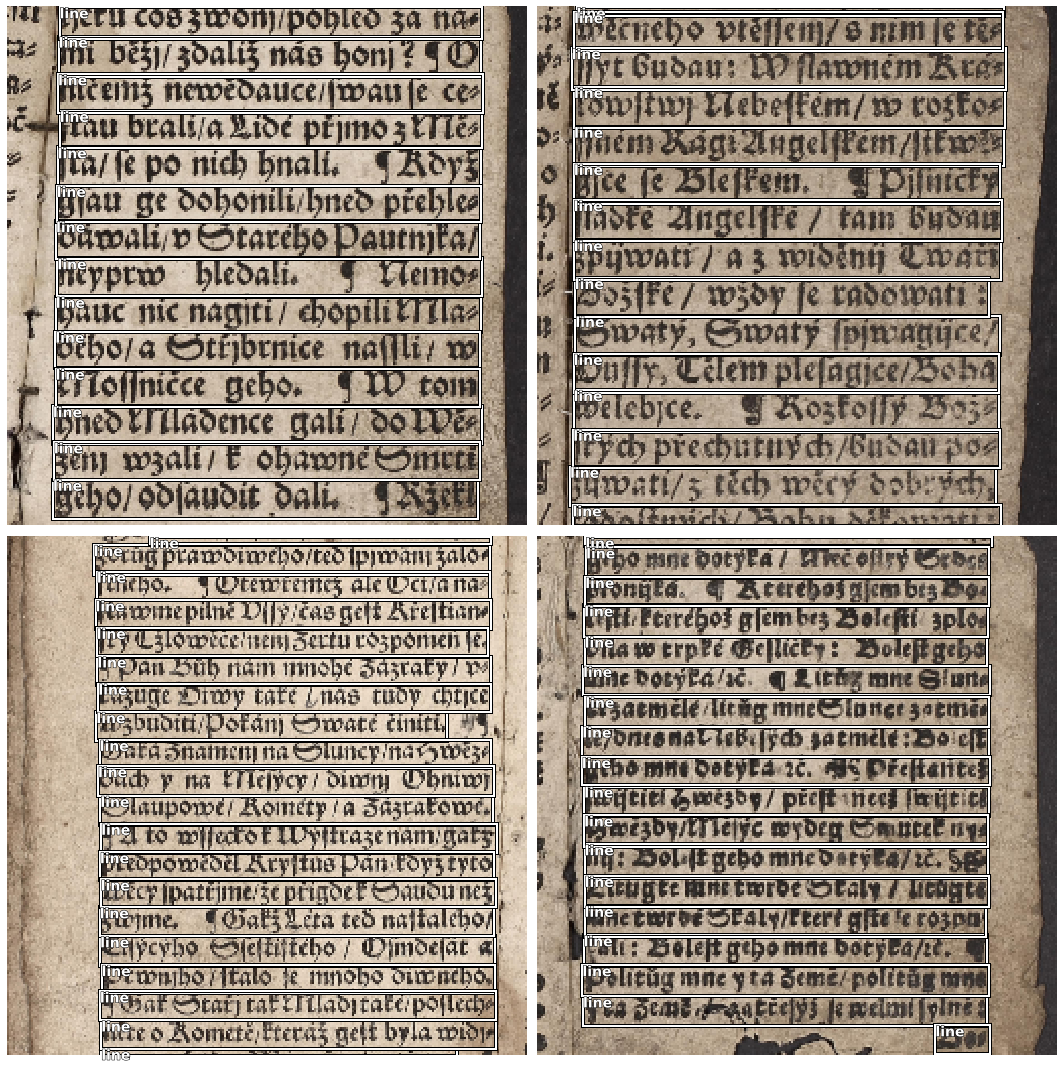

In [18]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))

In [19]:
data.classes

['background', 'line']

In [113]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[20, 1, 3], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])
#anchors = create_anchors(sizes=[(16,16),(8,8),(4,4)], ratios=[2, 1, 4], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [114]:
len(anchors)

24480

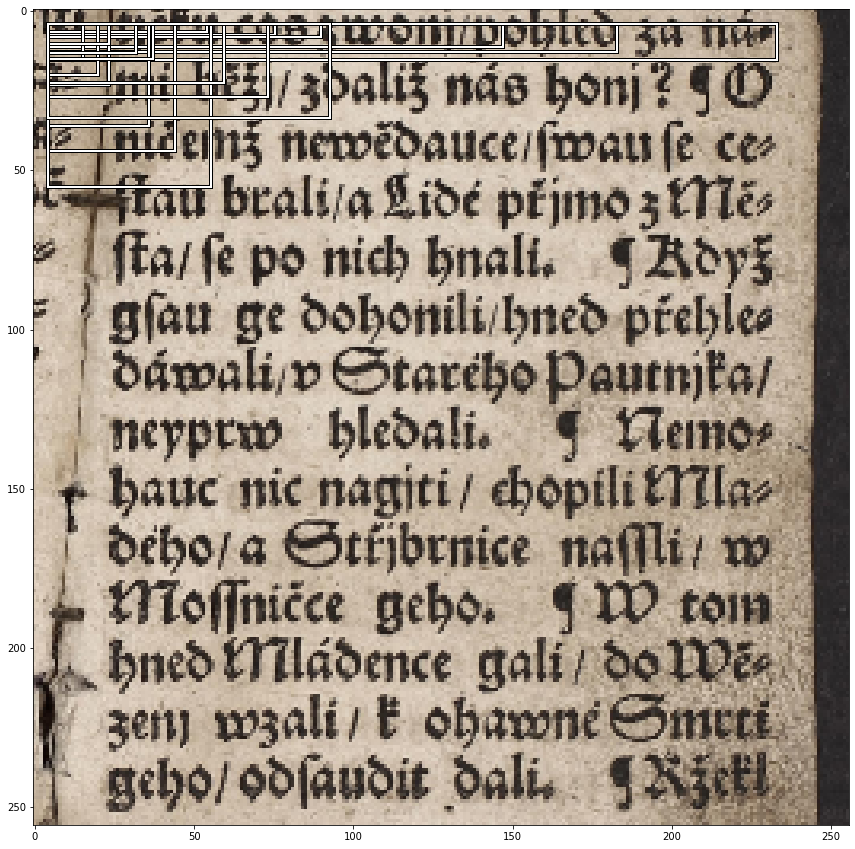

In [115]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

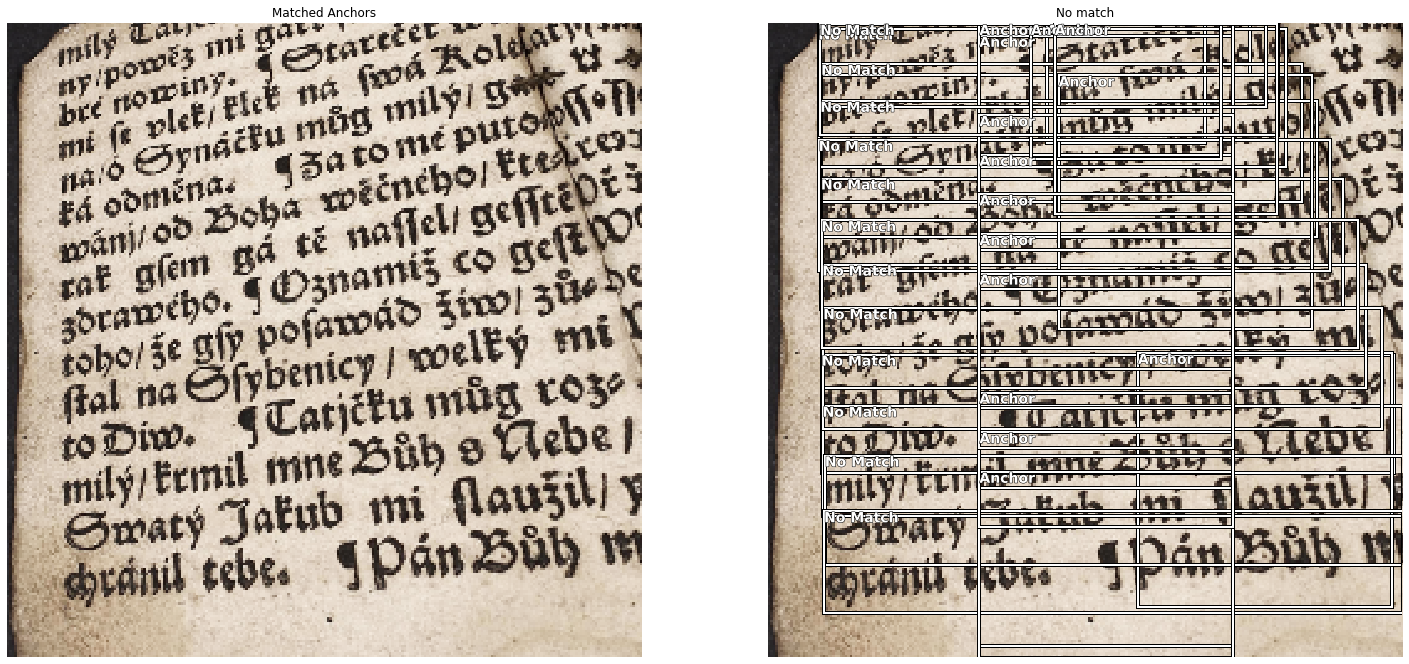

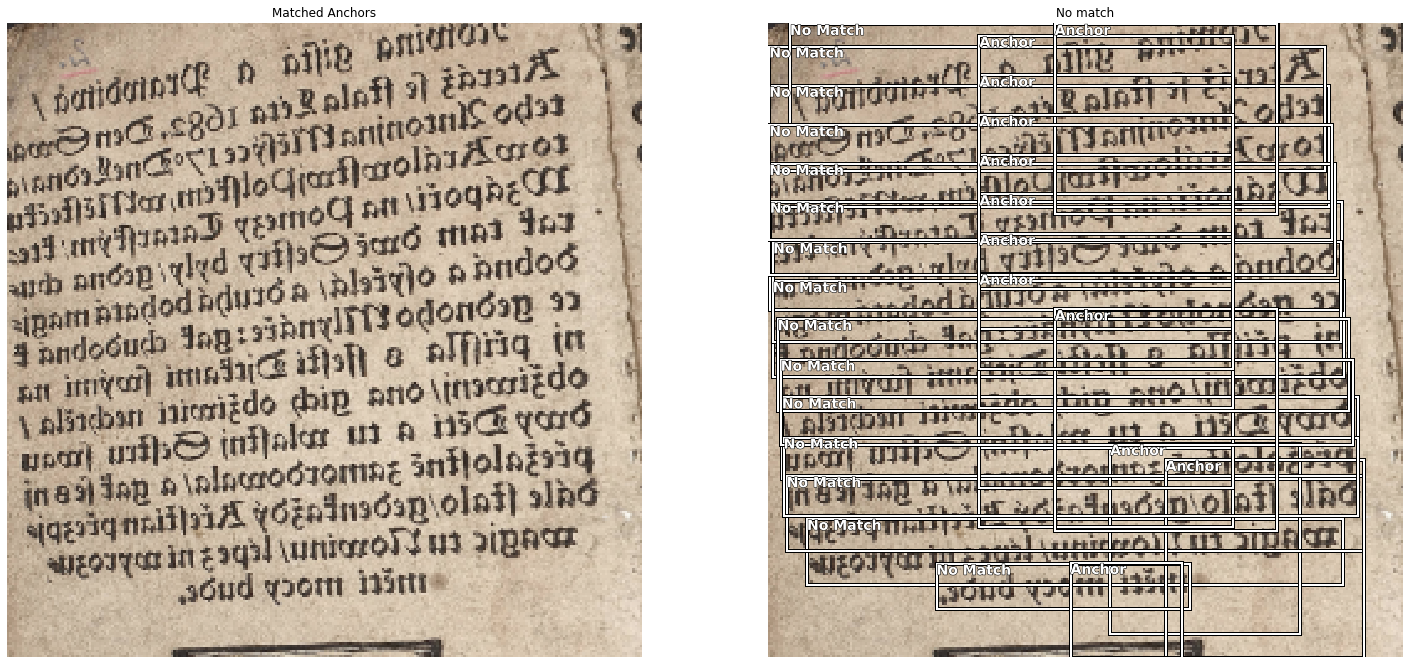

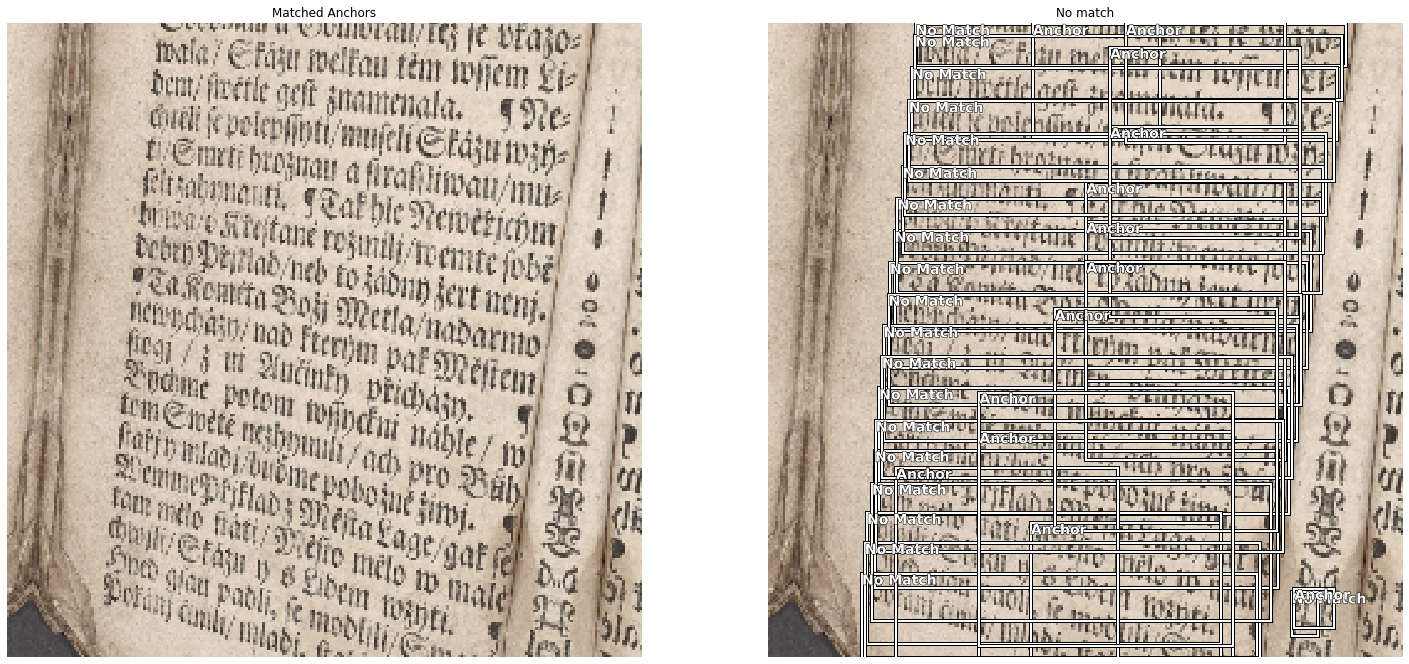

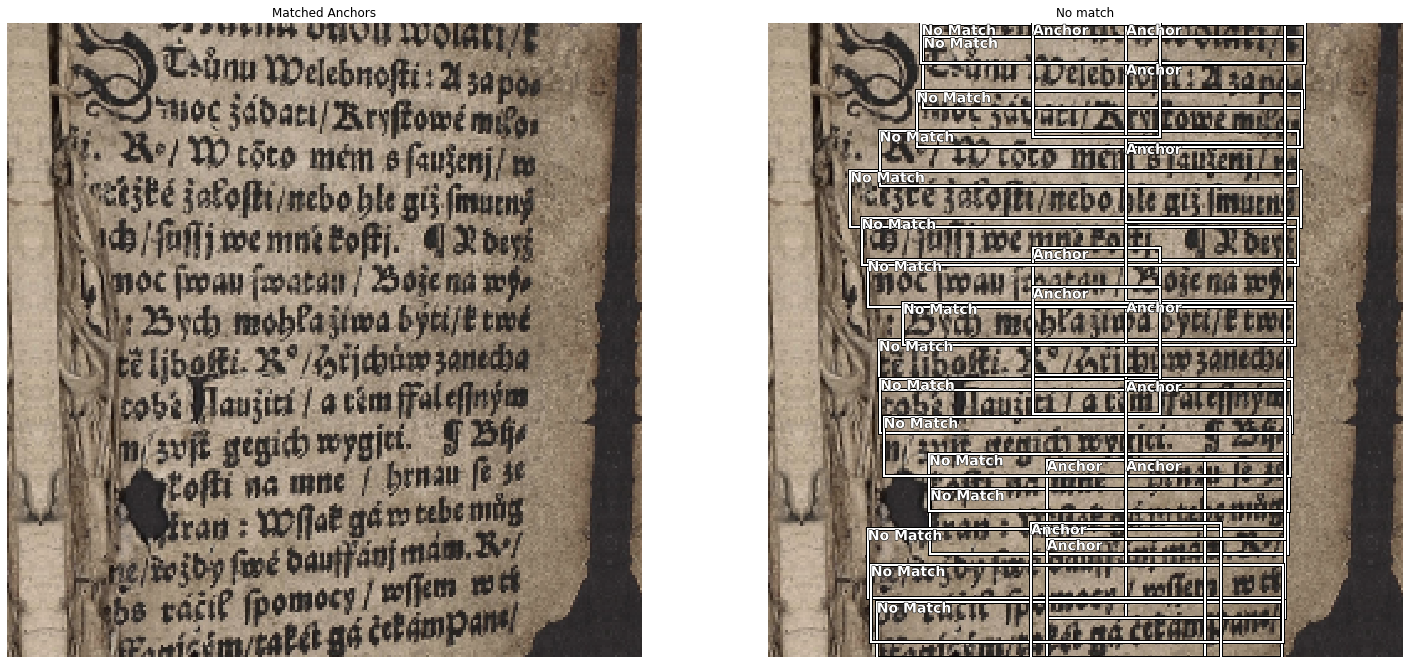

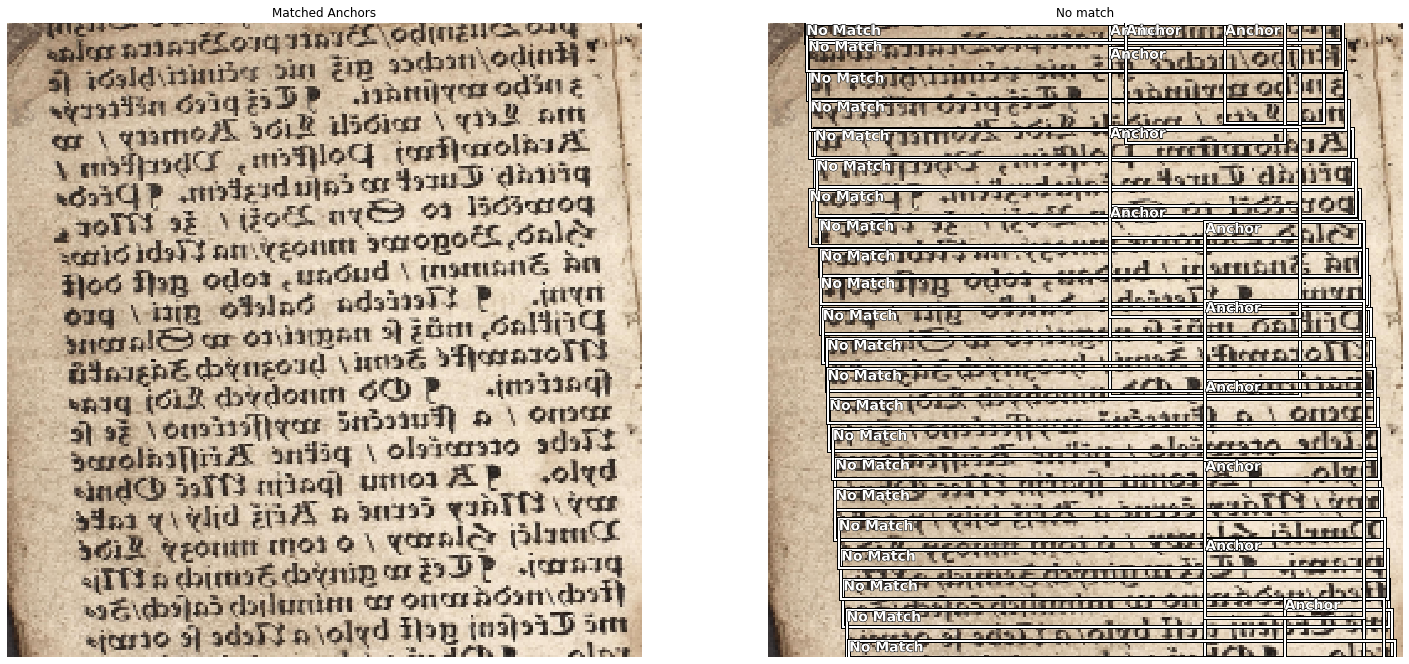

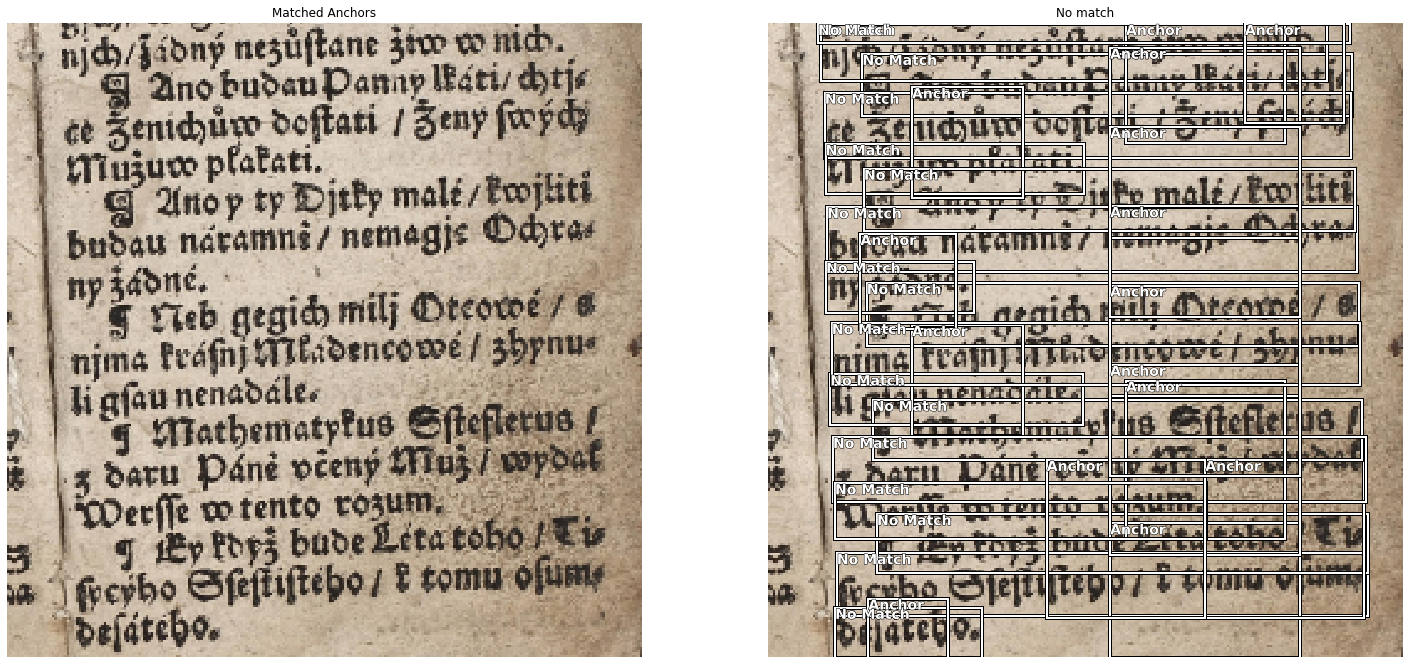

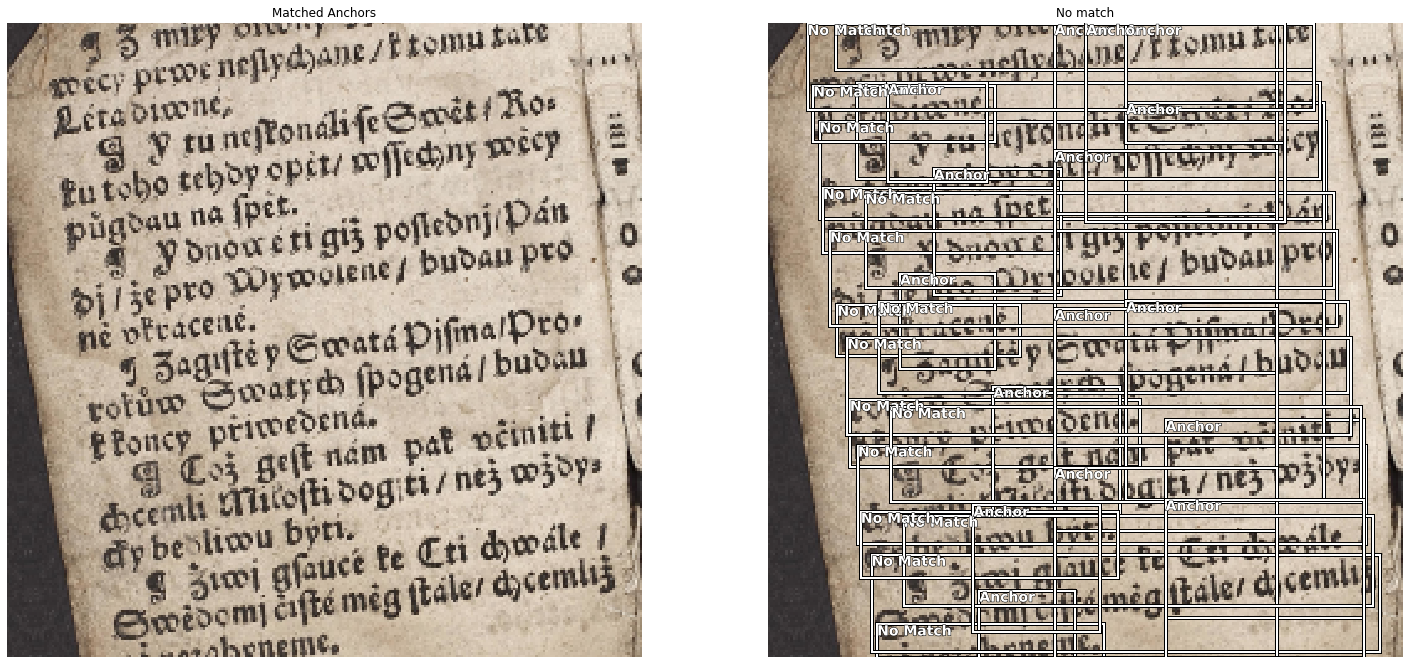

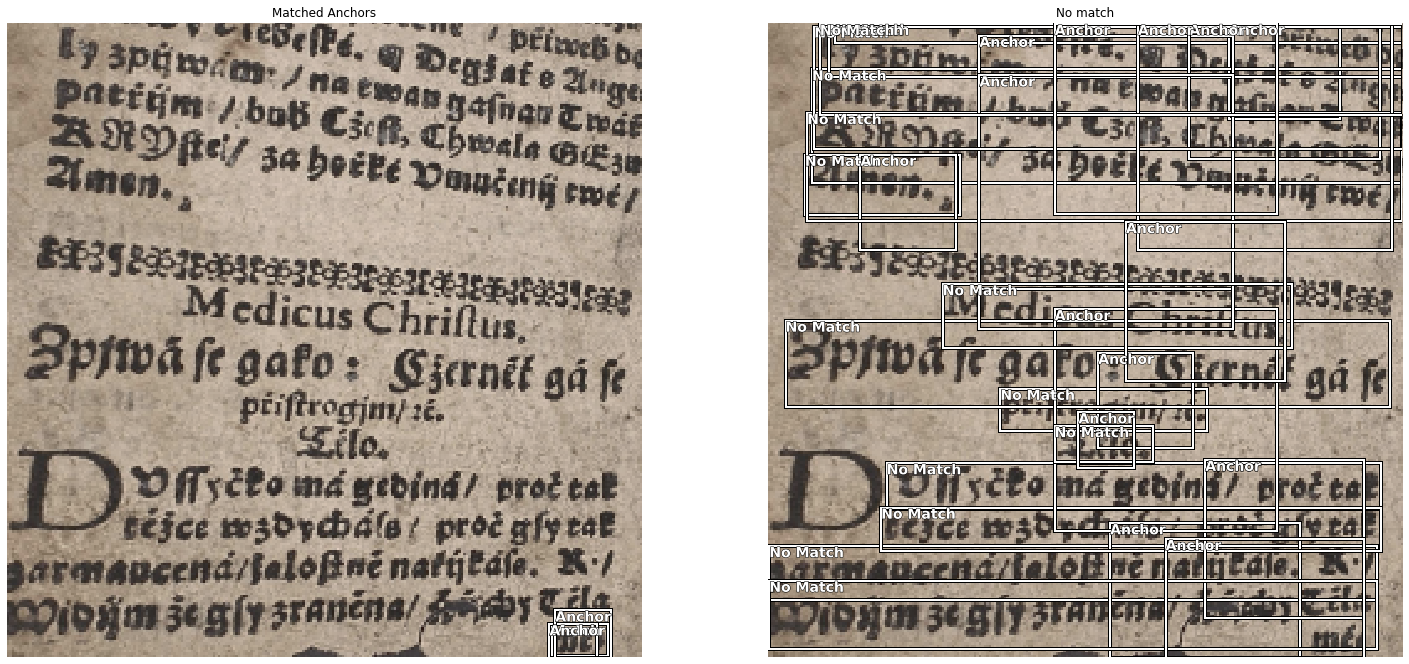

In [116]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

In [117]:
data.train_ds.c

2

In [118]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)
#model.eval()

In [119]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [120]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 2.29E-05


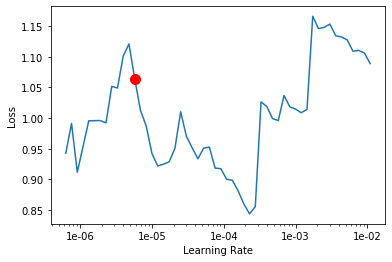

In [121]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

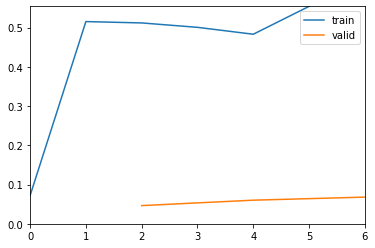

In [122]:
learn.fit_one_cycle(3, 1e-3)

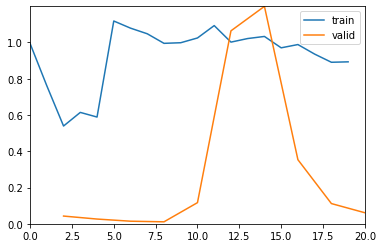

In [123]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

In [124]:
data.train_ds.classes

['background', 'line']

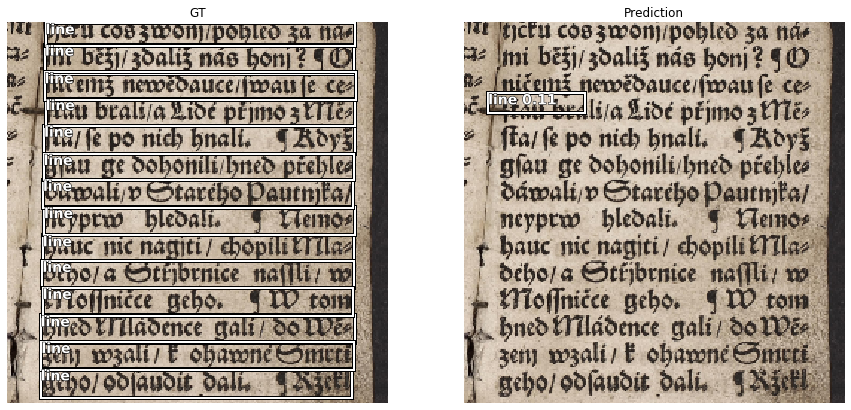

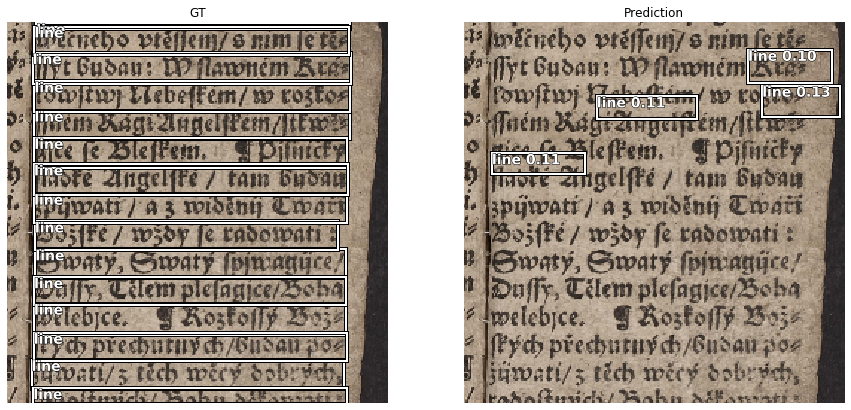

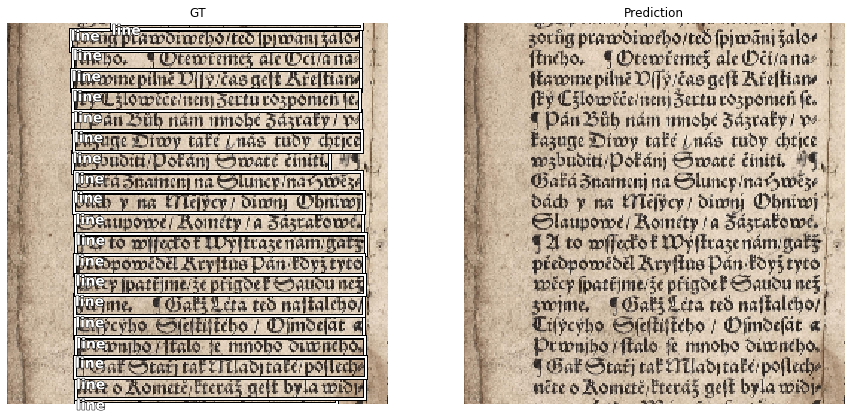

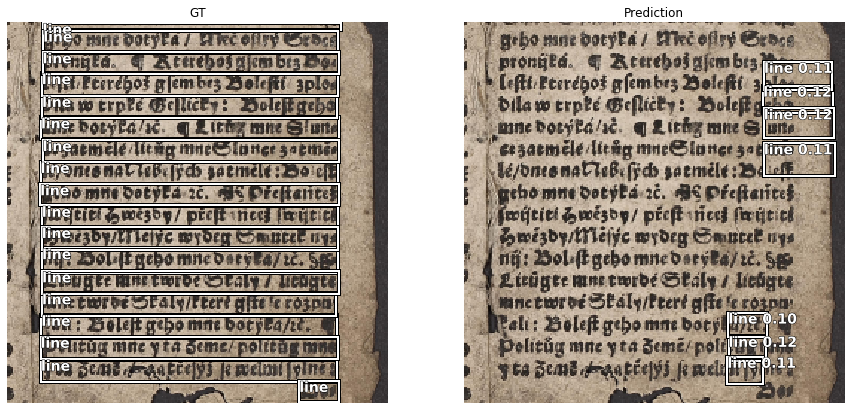

In [126]:
show_results_side_by_side(learn, anchors, detect_thresh=0.1, nms_thresh=0.1, image_count=20)